In [1]:
# !pip install fastparquet

In [2]:
# !pip install pandas -U

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_percentage_error as mape, r2_score

from collections import defaultdict
import torch
import matplotlib.pyplot as plt

In [4]:
torch.use_deterministic_algorithms(True)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train = pd.read_csv('drive/MyDrive/hackaton_sfo/train.csv')#.iloc[104:]
test = pd.read_csv('drive/MyDrive/hackaton_sfo/test.csv')

In [7]:
train[train.select_dtypes('object').columns] = train.loc[:, train.select_dtypes('object').columns].replace(' ', 0).astype('float')
test[test.select_dtypes('object').columns] = test.loc[:, test.select_dtypes('object').columns].replace(' ', 0).astype('float')

# EDA & Processing

In [8]:
pd.set_option('display.max_columns', 250)

In [9]:
train.head(3)

,year,week,week_beg,revenue,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,1_video_rating,1_video_money,1_video_coverage_5,2_video_rating,2_video_money,2_video_coverage_5,3_video_rating,3_video_money,3_video_coverage_5,4_video_rating,4_video_money,4_video_coverage_5,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,1_competitor_rating,1_competitor_coverage,1_competitor_money,1_competitor_digital,1_competitor_sponsorship_money,1_competitor_oon_money,1_competitor_radio_money,1_competitor_total,2_competitor_rating,2_competitor_coverage,2_competitor_money,2_competitor_digital,2_competitor_sponsorship_money,2_competitor_oon_money,2_competitor_radio_money,2_competitor_total,3_competitor_rating,3_competitor_coverage,3_competitor_money,3_competitor_digital,3_competitor_sponsorship_money,3_competitor_oon_money,3_competitor_radio_money,3_competitor_tv_reg,3_competitor_total,4_competitor_rating,4_competitor_coverage,4_competitor_money,4_competitor_digital,4_competitor_sponsorship_money,4_competitor_oon_money,4_competitor_radio_money,4_competitor_total,5_competitor_rating,5_competitor_coverage,5_competitor_money,5_competitor_digital,5_competitor_sponsorship_money,5_competitor_oon_money,5_competitor_radio_money,5_competitor_tv_reg,5_competitor_total,6_competitor_rating,6_competitor_coverage,6_competitor_money,6_competitor_digital,6_competitor_sponsorship_money,6_competitor_oon_money,6_competitor_radio_money,6_competitor_tv_reg,6_competitor_total,7_competitor_rating,7_competitor_coverage,7_competitor_money,7_competitor_digital,7_competitor_sponsorship_money,7_competitor_oon_money,7_competitor_radio_money,7_competitor_tv_reg,7_competitor_total,8_competitor_rating,8_competitor_coverage,8_competitor_money,8_competitor_digital,8_competitor_sponsorship_money,8_competitor_oon_money,8_competitor_radio_money,8_competitor_total,9_competitor_rating,9_competitor_coverage,9_competitor_money,9_competitor_digital,9_competitor_sponsorship_money,9_competitor_oon_money,9_competitor_radio_money,9_competitor_tv_reg,9_competitor_total,10_competitor_rating,10_competitor_coverage,10_competitor_money,10_competitor_digital,10_competitor_sponsorship_money,10_competitor_oon_money,10_competitor_radio_money,10_competitor_total,11_competitor_rating,11_competitor_coverage,11_competitor_money,11_competitor_digital,11_competitor_sponsorship_money,11_competitor_oon_money,11_competitor_radio_money,11_competitor_total,12_competitor_rating,12_competitor_coverage,12_competitor_money,12_competitor_digital,12_competitor_sponsorship_money,12_competitor_oon_money,12_competitor_radio_money,12_competitor_tv_reg,12_competitor_total,13_competitor_rating,13_competitor_coverage,13_competitor_money,13_competitor_digital,13_competitor_sponsorship_money,13_competitor_oon_money,13_competitor_radio_money,13_competitor_total
0,2019,1,15462144,4.153557e+07,114621.15,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92107,99698.595433,508956.0,1.54132,0.0,0.0,0.000000,0.000000e+00,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000,1057612.5,0.0,0.0,76854.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.606934e+06,1.606934e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.813979e+06,3.813979e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294.149196,23.6985,5.174524e+06,0.0,0.0,0.0,0.0,0.0,5.174524e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.114917,21.9240,5.670257e+06,227587.5,0.0,0.0,0.0,5.897845e+06,191.587053,9.8385,1.645239e+06,3.033352e+06,0.0,0.0,0.0,7.155664e+06,1.183425e+07,207.903106,15.3615,9.085528e+06,0.0,0.0,0.0,0.0,9.085528e+06
1,2019,2,15468192,5.122229e+07,141523.20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92107,99698.595433,804825.0,1.54132,0.0,0.0,7.295625,5.455512e+06,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [10]:
# train = train.drop(columns=['week_beg'])
train.insert(0, 'week_number', train.index.values)
train.shape

(244, 149)

In [11]:
for col in ['_competitor_rating',
 '_competitor_coverage',
 '_competitor_money',
 '_competitor_digital',
 '_competitor_sponsorship_money',
 '_competitor_oon_money',
 '_competitor_radio_money',
#  '_competitor_tv_reg',
 '_competitor_total']:

    train['competitors_'+col.rsplit('_', 1)[-1]] = train[[str(i) + col for i in range(1, 14)]].sum(axis=1)
    train.drop(columns=[str(i) + col for i in range(1, 14)], inplace=True)


col = '_competitor_tv_reg'
train['competitors_tv_reg'] = train[[str(i) + '_competitor_tv_reg' for i in [3, 5, 6, 7, 9, 12]]].sum(axis=1)
train.drop(columns=[str(i) + '_competitor_tv_reg' for i in [3, 5, 6, 7, 9, 12]], inplace=True)

In [12]:
for col in ['_video_rating',
 '_video_money',
 '_video_coverage_5']:
#
    train.drop(columns=[str(i) + col for i in range(1, 5)], inplace=True)


In [13]:
def get_season(x):
    if x in [12, 1, 2]:
        return 0 # 'winter'
    elif x in [3, 4, 5]:
        return 1 # 'spring'
    elif x in [6, 7, 8]:
        return 2 # 'summer'
    elif x in [9, 10, 11]:
        return 4 # 'autumn'

train['season'] = train['month'].apply(get_season)

In [14]:
train

,week_number,year,week,week_beg,revenue,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,competitors_rating,competitors_coverage,competitors_money,competitors_digital,competitors_total,competitors_tv_reg,season
0,0,2019,1,15462144,4.153557e+07,114621.15,12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,508956.0,1.541320,0.000000,0.00,0.000000,0.000000e+00,0.0000,1057612.50,0.000000e+00,0.0,76854.75,986.754273,70.8225,0.0,3.260939e+06,3.741306e+07,1.257658e+07,0
1,1,2019,2,15468192,5.122229e+07,141523.20,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,804825.0,1.541320,0.000000,0.00,7.295625,5.728288e+06,0.0000,844452.00,0.000000e+00,0.0,89113.50,946.781667,74.2560,0.0,3.958258e+06,4.380240e+07,1.467267e+07,0
2,2,2019,3,15474240,5.712735e+07,157926.30,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,993384.0,1.541320,0.000000,0.00,404.324055,6.683002e+06,32.8020,1235682.00,0.000000e+00,0.0,96066.60,720.023574,50.5050,0.0,2.183139e+06,4.806423e+07,1.467267e+07,0
3,3,2019,4,15480288,6.304099e+07,173746.65,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,1186542.0,1.541320,0.000000,0.00,310.839867,6.683002e+06,25.5570,538272.00,0.000000e+00,0.0,99189.30,473.033278,30.6915,0.0,1.394726e+06,3.520193e+07,1.467267e+07,0
4,4,2019,5,15486336,6.733689e+07,185551.80,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,1454817.0,1.541320,0.000000,0.00,319.546485,6.683002e+06,26.7855,0.00,0.000000e+00,0.0,108418.80,962.570639,76.7550,0.0,1.664996e+06,5.393971e+07,1.588468e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,239,2023,31,16907616,5.693151e+07,110088.30,7,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,367920.0,1.542399,0.063335,15.75,0.000000,0.000000e+00,0.0000,3278646.00,0.000000e+00,0.0,57033.90,32.372666,0.7875,0.0,8.001000e+03,1.627634e+06,0.000000e+00,2
240,240,2023,32,16913664,5.988151e+07,115345.65,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,390915.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,2701755.00,0.000000e+00,0.0,56645.40,26.624656,0.9450,0.0,9.450000e+02,1.895251e+06,0.000000e+00,2
241,241,2023,33,16919712,6.111218e+07,117761.70,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,398580.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,408240.00,0.000000e+00,0.0,59285.10,196.657494,11.8335,0.0,1.890000e+05,2.981865e+06,0.000000e+00,2
242,242,2023,34,16925760,6.159493e+07,118356.00,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,429240.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,309723.75,0.000000e+00,0.0,59583.30,293.515555,19.8975,0.0,2.484090e+05,1.007318e+07,0.000000e+00,2


In [15]:
# competititors_with_reg_tv = [3, 5, 6, 7, 9, 12]

In [16]:
# num_cols = ['week_number', 'disease_rate']

In [17]:
num_cols = train.columns.values.tolist()
num_cols.remove('week_beg')
num_cols.remove('revenue')
num_cols[:5]

['week_number', 'year', 'week', 'quantity', 'month']

In [18]:
binary_cols = []
# num_cols = ['age', 'duration', 'subscribers_count']
# sort_actions_col = ['week_beg']
time_cols = []
id_cols = []
target_col = ['revenue']

In [19]:
train = train[num_cols+target_col]
train.head(3)

,week_number,year,week,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,competitors_rating,competitors_coverage,competitors_money,competitors_digital,competitors_total,competitors_tv_reg,season,revenue
0,0,2019,1,114621.15,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92107,99698.595433,508956.0,1.54132,0.0,0.0,0.000000,0.000000e+00,0.000,1057612.5,0.0,0.0,76854.75,986.754273,70.8225,0.0,3.260939e+06,3.741306e+07,1.257658e+07,0,4.153557e+07
1,1,2019,2,141523.20,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92107,99698.595433,804825.0,1.54132,0.0,0.0,7.295625,5.728288e+06,0.000,844452.0,0.0,0.0,89113.50,946.781667,74.2560,0.0,3.958258e+06,4.380240e+07,1.467267e+07,0,5.122229e+07
2,2,2019,3,157926.30,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.92107,99698.595433,993384.0,1.54132,0.0,0.0,404.324055,6.683002e+06,32.802,1235682.0,0.0,0.0,96066.60,720.023574,50.5050,0.0,2.183139e+06,4.806423e+07,1.467267e+07,0,5.712735e+07


In [20]:
train

,week_number,year,week,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,competitors_rating,competitors_coverage,competitors_money,competitors_digital,competitors_total,competitors_tv_reg,season,revenue
0,0,2019,1,114621.15,12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,508956.0,1.541320,0.000000,0.00,0.000000,0.000000e+00,0.0000,1057612.50,0.000000e+00,0.0,76854.75,986.754273,70.8225,0.0,3.260939e+06,3.741306e+07,1.257658e+07,0,4.153557e+07
1,1,2019,2,141523.20,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,804825.0,1.541320,0.000000,0.00,7.295625,5.728288e+06,0.0000,844452.00,0.000000e+00,0.0,89113.50,946.781667,74.2560,0.0,3.958258e+06,4.380240e+07,1.467267e+07,0,5.122229e+07
2,2,2019,3,157926.30,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,993384.0,1.541320,0.000000,0.00,404.324055,6.683002e+06,32.8020,1235682.00,0.000000e+00,0.0,96066.60,720.023574,50.5050,0.0,2.183139e+06,4.806423e+07,1.467267e+07,0,5.712735e+07
3,3,2019,4,173746.65,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,1186542.0,1.541320,0.000000,0.00,310.839867,6.683002e+06,25.5570,538272.00,0.000000e+00,0.0,99189.30,473.033278,30.6915,0.0,1.394726e+06,3.520193e+07,1.467267e+07,0,6.304099e+07
4,4,2019,5,185551.80,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.0,0.92107,99698.595433,1454817.0,1.541320,0.000000,0.00,319.546485,6.683002e+06,26.7855,0.00,0.000000e+00,0.0,108418.80,962.570639,76.7550,0.0,1.664996e+06,5.393971e+07,1.588468e+07,0,6.733689e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,239,2023,31,110088.30,7,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,367920.0,1.542399,0.063335,15.75,0.000000,0.000000e+00,0.0000,3278646.00,0.000000e+00,0.0,57033.90,32.372666,0.7875,0.0,8.001000e+03,1.627634e+06,0.000000e+00,2,5.693151e+07
240,240,2023,32,115345.65,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,390915.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,2701755.00,0.000000e+00,0.0,56645.40,26.624656,0.9450,0.0,9.450000e+02,1.895251e+06,0.000000e+00,2,5.988151e+07
241,241,2023,33,117761.70,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,398580.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,408240.00,0.000000e+00,0.0,59285.10,196.657494,11.8335,0.0,1.890000e+05,2.981865e+06,0.000000e+00,2,6.111218e+07
242,242,2023,34,118356.00,8,4.154829e+08,2.436900e+08,1.227134e+08,2.929457e+07,412081.95,318306.45,22667.4,0.99750,64408.584220,429240.0,1.566483,0.070484,15.75,0.000000,0.000000e+00,0.0000,309723.75,0.000000e+00,0.0,59583.30,293.515555,19.8975,0.0,2.484090e+05,1.007318e+07,0.000000e+00,2,6.159493e+07


In [21]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train[num_cols] = ss.fit_transform(train[num_cols])

<ipython-input-21-ea45f70d9df5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[num_cols] = ss.fit_transform(train[num_cols])


In [22]:
# train['revenue'][train['revenue']>1.2e8] = 1.2e8
# train['revenue'][train['revenue']>1e8] = 1e8

In [23]:
ss_target = StandardScaler()

train[['revenue']] = ss_target.fit_transform(train[['revenue']])

train['revenue']

<ipython-input-23-872c8609a2bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['revenue']] = ss_target.fit_transform(train[['revenue']])


0     -1.239612
1     -0.785517
2     -0.508699
3     -0.231479
4     -0.030095
         ...   
239   -0.517880
240   -0.379589
241   -0.321898
242   -0.299268
243   -0.228400
Name: revenue, Length: 244, dtype: float64

<Axes: >

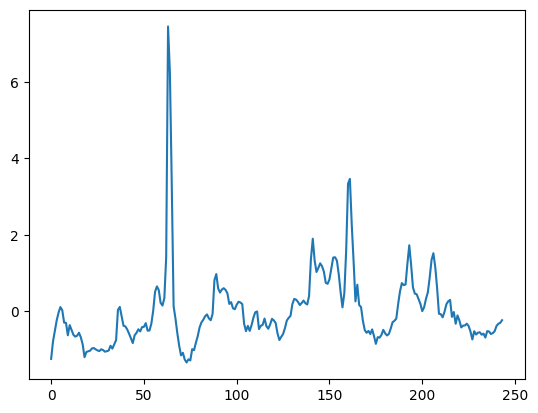

In [24]:
train['revenue'].plot()

# DataSet & DataLoader

DJNKSANDJKLH&*#Y&*@UG@#UYEG@#YDH#K@JHDKJLKSKWLJDE

In [25]:
X_train, y_train = train[num_cols + ['revenue']], train[target_col]

In [26]:
# X_train, y_train = train[num_cols], train[target_col]

In [27]:
num_preds = 29

In [28]:
use_val_dataset = True

if use_val_dataset:
    X_train, X_val = X_train.iloc[:-num_preds], X_train.iloc[-num_preds:]
    y_train, y_val = y_train.iloc[:-num_preds], y_train.iloc[-num_preds:]

ROLLING WINDOW

In [29]:
# X_train = X_train.rolling(5).mean().iloc[4:]
# y_train = y_train.rolling(5).mean().iloc[4:]

In [30]:
X_train

,week_number,year,week,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,competitors_rating,competitors_coverage,competitors_money,competitors_digital,competitors_total,competitors_tv_reg,season,revenue
0,-1.724967,-1.370169,-1.649376,-0.851225,1.695218,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,-0.835837,-0.244254,-0.896144,-0.756028,-0.623306,-0.616481,-0.632863,0.203050,-0.06415,-0.06415,-0.055324,1.679593,1.609931,-0.27716,0.543644,0.644890,1.095746,-1.178461,-1.239612
1,-1.710769,-1.370169,-1.581749,-0.345491,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,-0.179470,-0.244254,-0.896144,-0.756028,-0.581558,-0.043053,-0.632863,0.074749,-0.06415,-0.06415,0.557338,1.568750,1.737995,-0.27716,0.837203,0.935710,1.398324,-1.178461,-0.785517
2,-1.696572,-1.370169,-1.514122,-0.037127,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,0.238837,-0.244254,-0.896144,-0.756028,1.690351,0.052518,1.831097,0.310229,-0.06415,-0.06415,0.904836,0.939954,0.852119,-0.27716,0.089910,1.129692,1.398324,-1.178461,-0.508699
3,-1.682375,-1.370169,-1.446495,0.260281,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,0.667346,-0.244254,-0.896144,-0.756028,1.155408,0.052518,1.286880,-0.109541,-0.06415,-0.06415,1.060901,0.255054,0.113105,-0.27716,-0.241998,0.544247,1.398324,-1.178461,-0.231479
4,-1.668178,-1.370169,-1.378868,0.482207,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,1.262497,-0.244254,-0.896144,-0.756028,1.205230,0.052518,1.379160,-0.433526,-0.06415,-0.06415,1.522169,1.612532,1.831204,-0.27716,-0.128219,1.397123,1.573281,-1.178461,-0.030095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1.256457,1.581895,-1.581749,-0.665579,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.657143,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.326522,0.788661,0.715830,-0.27716,0.224999,0.584875,-0.719723,-1.178461,-0.070879
211,1.270655,1.581895,-1.514122,-0.725744,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.493901,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.329093,0.890231,0.765176,-0.27716,-0.037647,0.455516,-0.719723,-1.178461,-0.152823
212,1.284852,1.581895,-1.446495,-0.608573,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.687751,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.380468,0.533454,0.436203,-0.27716,-0.192070,0.545420,-0.719723,-1.178461,-0.005535
213,1.299049,1.581895,-1.378868,-0.457095,-1.554757,0.268160,0.244570,0.207908,0.583549,-0.085084,-0.078413,0.116237,0.900943,-1.238912,0.980225,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.129683,1.221402,1.294665,-0.27716,0.143279,0.753711,-0.718302,-1.178461,0.186623


In [31]:
y_val_unscaled = ss_target.inverse_transform(y_val)
y_train_unscaled = ss_target.inverse_transform(y_train)

In [32]:
X_train

,week_number,year,week,quantity,month,month_revenue,150_r,50_r,500_r,150_q,50_q,500_q,distribution,prescribes,disease_rate,price_index,generics_avg,generics_brands,total_video_rating,total_video_coverage_5,total_video_coverage_5.1,digital_money,radio_money,radio_times,wordstat,competitors_rating,competitors_coverage,competitors_money,competitors_digital,competitors_total,competitors_tv_reg,season,revenue
0,-1.724967,-1.370169,-1.649376,-0.851225,1.695218,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,-0.835837,-0.244254,-0.896144,-0.756028,-0.623306,-0.616481,-0.632863,0.203050,-0.06415,-0.06415,-0.055324,1.679593,1.609931,-0.27716,0.543644,0.644890,1.095746,-1.178461,-1.239612
1,-1.710769,-1.370169,-1.581749,-0.345491,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,-0.179470,-0.244254,-0.896144,-0.756028,-0.581558,-0.043053,-0.632863,0.074749,-0.06415,-0.06415,0.557338,1.568750,1.737995,-0.27716,0.837203,0.935710,1.398324,-1.178461,-0.785517
2,-1.696572,-1.370169,-1.514122,-0.037127,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,0.238837,-0.244254,-0.896144,-0.756028,1.690351,0.052518,1.831097,0.310229,-0.06415,-0.06415,0.904836,0.939954,0.852119,-0.27716,0.089910,1.129692,1.398324,-1.178461,-0.508699
3,-1.682375,-1.370169,-1.446495,0.260281,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,0.667346,-0.244254,-0.896144,-0.756028,1.155408,0.052518,1.286880,-0.109541,-0.06415,-0.06415,1.060901,0.255054,0.113105,-0.27716,-0.241998,0.544247,1.398324,-1.178461,-0.231479
4,-1.668178,-1.370169,-1.378868,0.482207,-1.554757,-1.607440,-1.582970,-1.631552,-1.594297,-1.486439,-1.562259,-1.529891,-0.897740,1.545501,1.262497,-0.244254,-0.896144,-0.756028,1.205230,0.052518,1.379160,-0.433526,-0.06415,-0.06415,1.522169,1.612532,1.831204,-0.27716,-0.128219,1.397123,1.573281,-1.178461,-0.030095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1.256457,1.581895,-1.581749,-0.665579,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.657143,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.326522,0.788661,0.715830,-0.27716,0.224999,0.584875,-0.719723,-1.178461,-0.070879
211,1.270655,1.581895,-1.514122,-0.725744,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.493901,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.329093,0.890231,0.765176,-0.27716,-0.037647,0.455516,-0.719723,-1.178461,-0.152823
212,1.284852,1.581895,-1.446495,-0.608573,-1.554757,1.053703,1.112498,0.755586,1.132012,0.647251,0.393667,0.559158,0.900943,-1.238912,0.687751,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.380468,0.533454,0.436203,-0.27716,-0.192070,0.545420,-0.719723,-1.178461,-0.005535
213,1.299049,1.581895,-1.378868,-0.457095,-1.554757,0.268160,0.244570,0.207908,0.583549,-0.085084,-0.078413,0.116237,0.900943,-1.238912,0.980225,1.661972,1.740521,1.783394,-0.623306,-0.616481,-0.632863,-0.433526,-0.06415,-0.06415,-0.129683,1.221402,1.294665,-0.27716,0.143279,0.753711,-0.718302,-1.178461,0.186623


In [33]:
class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window=52, num_preds=29):
        self.X = X
        self.y = y
        self.window = window
        self.num_preds = num_preds

    def __len__(self):
        return self.X.__len__() - self.window + 1

    def __getitem__(self, index):
        return (self.X[index:index+self.window], self.y[index+self.window:index+self.window+self.num_preds].reshape(-1))

In [34]:
sliding_window = 104
# num_preds = 50

In [35]:
train_dataset = TimeseriesDataset(torch.tensor(X_train.values), torch.tensor(y_train.values), window=sliding_window, num_preds=num_preds)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)

In [36]:
# for i, d in enumerate(train_loader):
#     print(i, d[0].shape, d[1].shape)

In [37]:
num_features = X_train.shape[1]
dataset_length = len(train_dataset)

# Model

In [38]:
import random
import os
import torch.nn as nn
import torch.optim as optim
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader, Dataset
# from torch.nn import TransformerDecoder, TransformerDecoderLayer
# from torch.nn import Embedding
import pickle
from tqdm import tqdm
import os
import random

In [39]:
def seed_everything(seed):    # Provide reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

!mkdir checkpoints

In [40]:
class LstmTimeSeries(nn.Module):
    def __init__(
        self,
        hidden_size,
        num_layers,
        num_preds
    ):
        super(LstmTimeSeries, self).__init__()

        self.is_bidectional = False

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.is_bidectional
        )

        lstm_output_dim = hidden_size * (1 + self.is_bidectional)

        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_output_dim, lstm_output_dim//2)

        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(lstm_output_dim//2, lstm_output_dim//2)

        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(lstm_output_dim//2, num_preds)

        self.num_layers = num_layers
        self.hidden_size = hidden_size


    def forward(self, X, hidden=None, cell=None):

        out, (h_n, c_n) = self.lstm(X, (hidden, cell))
        out = torch.mean(out, dim=1)

        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.dropout3(out)
        out = self.fc3(out)

        return out, h_n, c_n

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers * (1 + self.is_bidectional), batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * (1 + self.is_bidectional), batch_size, self.hidden_size).to(device)
        return h0, c0

In [47]:
# Training Setup
hidden_size = 512
num_layers = 1
learning_rate = 4e-2
epochs = 100
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LstmTimeSeries(
    hidden_size,
    num_layers,
    num_preds
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss(reduction='mean')

# Training

In [48]:
seed_everything(40)

final_metric_best = -10
epoch_best = 0

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    # for count_batch, (X, y) in enumerate(tqdm(train_loader)):
    for count_batch, (X, y) in enumerate(train_loader):

        hidden, cell = model.init_hidden(batch_size=batch_size)

        # if y.shape[1] < num_preds: continue

        if count_batch == dataset_length - 1: continue

        optimizer.zero_grad()


        pred, hidden, cell = model(X.float(), hidden, cell)



        loss = criterion(pred[:, :y.shape[1]], y.float())


        loss.backward()
        optimizer.step()

        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    loss = criterion(pred, torch.tensor(y_val.values).T)

    pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)
    mape_value = mape(y_val_unscaled.reshape(-1), pred)
    r2_score_value = r2_score(y_val_unscaled.reshape(-1), pred)
    final_metric = (1 - mape_value + r2_score_value)/2

    if final_metric >= final_metric_best:
        final_metric_best = final_metric
        epoch_best = epoch
        torch.save(model, f'checkpoints/{epoch}_{final_metric_best:3f}.pt')

    print('Validation RMSE:', round(loss.item()**0.5, 3), end=' ## ')
    print('Validation MAPE:', round(mape_value, 3), end=' ## ')
    print('R2_score:', round(r2_score_value, 3), end=' ## ')
    print('Final Metric', round(final_metric, 3))


    # try:
    #
    # except Exception as e:
    #     pass

print('BEST METRIC:', final_metric_best)

Epoch: 0, Train RMSE: 157.807
Validation RMSE: 171.119 ## Validation MAPE: 48.598 ## R2_score: -619582.27 ## Final Metric -309814.934
Epoch: 1, Train RMSE: 52.2
Validation RMSE: 31.253 ## Validation MAPE: 8.411 ## R2_score: -20666.289 ## Final Metric -10336.85
Epoch: 2, Train RMSE: 38.461
Validation RMSE: 17.646 ## Validation MAPE: 4.582 ## R2_score: -6587.494 ## Final Metric -3295.538
Epoch: 3, Train RMSE: 20.199
Validation RMSE: 5.348 ## Validation MAPE: 1.45 ## R2_score: -604.179 ## Final Metric -302.314
Epoch: 4, Train RMSE: 23.321
Validation RMSE: 5.4 ## Validation MAPE: 1.478 ## R2_score: -616.077 ## Final Metric -308.278
Epoch: 5, Train RMSE: 6.028
Validation RMSE: 1.987 ## Validation MAPE: 0.592 ## R2_score: -82.573 ## Final Metric -41.083
Epoch: 6, Train RMSE: 5.294
Validation RMSE: 1.937 ## Validation MAPE: 0.57 ## R2_score: -78.406 ## Final Metric -38.988
Epoch: 7, Train RMSE: 3.796
Validation RMSE: 2.005 ## Validation MAPE: 0.532 ## R2_score: -84.07 ## Final Metric -41.801


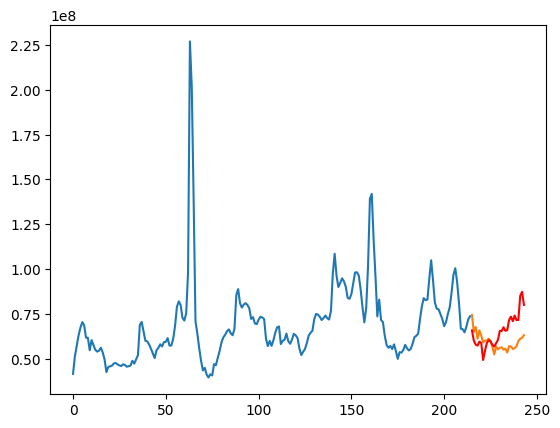

In [43]:
# plt.plot(y_train.index.values[-52:], y_train_unscaled[-52:])
plt.plot(y_train.index.values, y_train_unscaled)
plt.plot(y_val.index.values, y_val_unscaled)
plt.plot(y_val.index.values, pred.reshape(-1), c='r')

In [44]:
1/0

ZeroDivisionError: division by zero

In [ ]:
seed_everything(41)

final_metric_best = -10
epoch_best = 0
gradient_accumulation_steps = 4

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    loss = 0

    # for count_batch, (X, y) in enumerate(tqdm(train_loader)):
    for count_batch, (X, y) in enumerate(train_loader):


        hidden, cell = model.init_hidden(batch_size=batch_size)

        if y.shape[1] < num_preds: continue

        if count_batch == dataset_length - 1: continue


        pred, hidden, cell = model(X.float(), hidden, cell)


        loss = criterion(pred[:, :y.shape[1]], y.float()) / gradient_accumulation_steps
        loss.backward()

        if count_batch % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()


        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    loss = criterion(pred, torch.tensor(y_val.values).T)

    pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)
    mape_value = mape(y_val_unscaled.reshape(-1), pred)
    r2_score_value = r2_score(y_val_unscaled.reshape(-1), pred)
    final_metric = (1 - mape_value + r2_score_value)/2

    if final_metric >= final_metric_best:
        final_metric_best = final_metric
        epoch_best = epoch
        torch.save(model, f'checkpoints/{epoch}_{final_metric_best:3f}.pt')

    print('Validation RMSE:', round(loss.item()**0.5, 3), end=' ## ')
    print('Validation MAPE:', round(mape_value, 3), end=' ## ')
    print('R2_score:', round(r2_score_value, 3), end=' ## ')
    print('Final Metric', round(final_metric, 3))


    # try:
    #
    # except Exception as e:
    #     pass

print('BEST METRIC:', final_metric_best)

In [ ]:
# Training Setup
hidden_size = 128
num_layers = 1
learning_rate = 4e-4
epochs = 10
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LstmTimeSeries(
    hidden_size,
    num_layers,
    num_preds
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss(reduction='mean')

seed_everything(40)

final_metric_best = 0
epoch_best = 0

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    # for count_batch, (X, y) in enumerate(tqdm(train_loader)):
    for count_batch, (X, y) in enumerate(train_loader):

        hidden, cell = model.init_hidden(batch_size=batch_size)

        if y.shape[1] < num_preds: continue

        if count_batch == dataset_length - 1: continue

        optimizer.zero_grad()

        loss = 0

        pred, hidden, cell = model(X.float(), hidden, cell)



        loss = criterion(pred[:, :y.shape[1]], y.float())


        loss.backward()
        optimizer.step()

        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    loss = criterion(pred, torch.tensor(y_val.values).T)

    pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)
    mape_value = mape(y_val_unscaled.reshape(-1), pred)
    r2_score_value = r2_score(y_val_unscaled.reshape(-1), pred)
    final_metric = (1 - mape_value + r2_score_value)/2

    if final_metric >= final_metric_best:
        final_metric_best = final_metric
        epoch_best = epoch
        torch.save(model, f'checkpoints/{epoch}_{final_metric_best:3f}.pt')

    print('Validation RMSE:', round(loss.item()**0.5, 3), end=' ## ')
    print('Validation MAPE:', round(mape_value, 3), end=' ## ')
    print('R2_score:', round(r2_score_value, 3), end=' ## ')
    print('Final Metric', round(final_metric, 3))


    # try:
    #
    # except Exception as e:
    #     pass

print('BEST METRIC:', final_metric_best)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_train.index.values, y_train_unscaled)
plt.plot(y_val.index.values, y_val_unscaled)
plt.plot(y_val.index.values, pred.reshape(-1))

In [ ]:
seed_everything(41)

final_metric_best = 0
epoch_best = 0
best_pred = None

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    # for count_batch, (X, y) in enumerate(tqdm(train_loader)):
    for count_batch, (X, y) in enumerate(train_loader):

        hidden, cell = model.init_hidden(batch_size=batch_size)

        # if y.shape[1] < 29: continue

        if count_batch == dataset_length - 1: continue

        optimizer.zero_grad()

        loss = 0

        pred, hidden, cell = model(X.float(), hidden, cell)



        loss = criterion(pred[:, :y.shape[1]], y.float())


        loss.backward()
        optimizer.step()

        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    loss = criterion(pred, torch.tensor(y_val.values).T)

    pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)
    mape_value = mape(y_val_unscaled.reshape(-1), pred)
    r2_score_value = r2_score(y_val_unscaled.reshape(-1), pred)
    final_metric = (1 - mape_value + r2_score_value)/2

    if final_metric >= final_metric_best:
        final_metric_best = final_metric
        epoch_best = epoch
        torch.save(model, f'checkpoints/{epoch}_{final_metric_best:3f}.pt')
        best_pred = pred

    print('Validation RMSE:', round(loss.item()**0.5, 3), end=' ## ')
    print('Validation MAPE:', round(mape_value, 3), end=' ## ')
    print('R2_score:', round(r2_score_value, 3), end=' ## ')
    print('Final Metric', round(final_metric, 3))


    # try:
    #
    # except Exception as e:
    #     pass

print('BEST METRIC:', final_metric_best)

In [ ]:
seed_everything(5)

final_metric_best = 0
epoch_best = 0
best_pred = None

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    # for count_batch, (X, y) in enumerate(tqdm(train_loader)):
    for count_batch, (X, y) in enumerate(train_loader):

        hidden, cell = model.init_hidden(batch_size=batch_size)

        # if y.shape[1] < 29: continue

        if count_batch == dataset_length - 1: continue

        optimizer.zero_grad()

        loss = 0

        pred, hidden, cell = model(X.float(), hidden, cell)



        loss = criterion(pred[:, :y.shape[1]], y.float())


        loss.backward()
        optimizer.step()

        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    loss = criterion(pred, torch.tensor(y_val.values).T)

    pred = ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)
    mape_value = mape(y_val_unscaled.reshape(-1), pred)
    r2_score_value = r2_score(y_val_unscaled.reshape(-1), pred)
    final_metric = (1 - mape_value + r2_score_value)/2

    if final_metric >= final_metric_best:
        final_metric_best = final_metric
        epoch_best = epoch
        torch.save(model, f'checkpoints/{epoch}_{final_metric_best:3f}.pt')
    best_pred = pred

    print('Validation RMSE:', round(loss.item()**0.5, 3), end=' ## ')
    print('Validation MAPE:', round(mape_value, 3), end=' ## ')
    print('R2_score:', round(r2_score_value, 3), end=' ## ')
    print('Final Metric', round(final_metric, 3))


    # try:
    #
    # except Exception as e:
    #     pass

print('BEST METRIC:', final_metric_best)

In [ ]:
# model = torch.load('/content/checkpoints/24_0.476851.pt')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_val.index.values, y_val_unscaled)
plt.plot(y_val.index.values, best_pred.reshape(-1))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_train.index.values, y_train_unscaled)
plt.plot(y_val.index.values, y_val_unscaled)
plt.plot(y_val.index.values, pred.reshape(-1))

In [ ]:
print('Validation MAPE:', round(mape(y_val.values.reshape(-1), pred.detach().numpy().reshape(-1)), 3), end=' ## ')
print('R2_score:', round(r2_score(y_val.values.reshape(-1), pred.detach().numpy().reshape(-1)), 3))

In [ ]:
plt.plot(train['revenue'][-30:].index.values, train['revenue'][-30:].values)
plt.plot(train['revenue'][-29:].index.values, pred.detach().numpy().reshape(-1))

In [ ]:
y_train.mean()

In [ ]:
pred.mean()

# Обучение без валидации

In [ ]:
X_train, y_train = train[num_cols+target_col], train[target_col]

In [ ]:
# sliding_window = 104
num_preds = 29

In [ ]:
train_dataset = TimeseriesDataset(torch.tensor(X_train.values), torch.tensor(y_train.values), window=sliding_window, num_preds=num_preds)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = False)

In [ ]:
num_features = X_train.shape[1]
dataset_length = len(train_dataset)

In [ ]:
# Training Setup
hidden_size = 128
num_layers = 1
learning_rate = 3e-2
epochs = 15
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LstmTimeSeries(
    hidden_size,
    num_layers,
    num_preds
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

criterion = torch.nn.MSELoss(reduction='mean')

In [ ]:
seed_everything(42)

for epoch in range(epochs):
    # metrics = []
    # predicted_labels = []
    # true_labels = []
    model.train()

    for count_batch, (X, y) in enumerate(tqdm(train_loader)):

        # if y.shape[1] < 29: continue

        hidden, cell = model.init_hidden(batch_size=batch_size)

        if count_batch == dataset_length - 1: continue

        optimizer.zero_grad()

        loss = 0

        pred, hidden, cell = model(X.float(), hidden, cell)



        loss = criterion(pred[:, :y.shape[1]], y.float())


        loss.backward()
        optimizer.step()

        # if count_batch % 20 == 0 :
        #     print(f"Epoch {epoch} loss: {loss:.4f}")

    print(f'Epoch: {epoch}, Train RMSE: {round(loss.item()**0.5, 3)}')

    model.eval()
    loss = 0
    pred, hidden, cell = model(X.float(), hidden, cell)
    # loss = criterion(pred, torch.tensor(y_val.values).T)
    # print('Validation RMSE:', round(loss.item()**0.5))
    # print('Validation MAPE:', round(mape(y_val.values.reshape(-1), pred.detach().numpy().reshape(-1)), 3), end=' ## ')
    # print('R2_score:', round(r2_score(y_val.values.reshape(-1), pred.detach().numpy().reshape(-1)), 3))


    # try:
    #     torch.save(model, 'checkpoints/6_with_features.pt')
    # except Exception as e:
    #     pass

In [ ]:
# plt.plot(train['revenue'][-30:].index.values, train['revenue'][-30:].values)
pred_unscaled = pd.Series(ss_target.inverse_transform(pred.detach().numpy()).reshape(-1))
plt.plot(train['revenue'].index.values, ss_target.inverse_transform(train[['revenue']]).reshape(-1))
plt.plot(train['revenue'][-29:].index.values + 29, pred_unscaled)

In [ ]:
pd.Series(ss_target.inverse_transform(pred.detach().numpy()).reshape(-1)).to_csv('predicts_ufo.csv', index=False)

In [ ]:
1/0

In [ ]:
from google.colab import files
files.download('predicts_ufo.csv')